In [1]:
import numpy as np
import csv
import datetime
import timedelta
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
file = open("../Simplified_Dataset.csv")
csvreader = csv.reader(file)
rows = []
header = next(csvreader)
for row in csvreader:
    rows.append(row)
file.close()

(458, 1)
(197, 1)


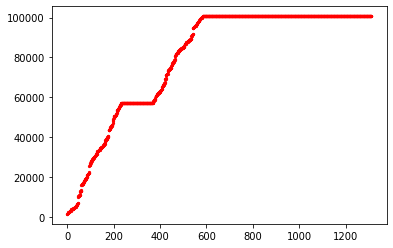

In [3]:
def add_minutes(Time, period):
    res = Time + datetime.timedelta(minutes = period)
    return res

account = input()
sum = 0.0
start_time = datetime.datetime.strptime("2020-10-04 14:30:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-10-05 12:20:00", "%Y-%m-%d %H:%M:%S")
period = 1
Time = start_time
sum = 0
index = 0
x = []
y = []

while Time <= end_time:
    x.append(index)
    Time = add_minutes(Time, period)
    index = index + 1

Time = start_time

for row in rows:
    str = row[4]
    str = str.removesuffix(" +UTC")
    cur_time = datetime.datetime.strptime(str, "%b-%d-%Y %I:%M:%S %p")
    while Time <= cur_time:
        y.append(sum)
        Time = add_minutes(Time, period)

    if row[1] == account:
        sum = sum - float(row[3])
    if row[2] == account:
        sum = sum + float(row[3])

while Time <= end_time:
    y.append(sum)
    Time = add_minutes(Time, period)

x = np.array(x).reshape(-1, 1)

train_size = int(x.shape[0] * 0.35)
test_end = int(x.shape[0] * 0.5)

x_train = x[:train_size]
x_test = x[train_size : test_end]
y_train = y[:train_size]
y_test = y[train_size : test_end]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)
scalar = StandardScaler()
x_train_scale = scalar.fit_transform(x_train)
x_test_scale = scalar.fit_transform(x_test)
scalarY = StandardScaler()
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
y_train_scale = scalarY.fit_transform(y_train)
y_test_scale = scalarY.fit_transform(y_test)
print(x_train.shape)
print(x_test.shape)
plt.scatter(x, y, s = 5, color = "red")
plt.show()

In [4]:
svr = SVR().fit(x_train_scale, y_train_scale)
print(svr)

SVR()


C:\Users\Acer Assfire 7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(197, 1)


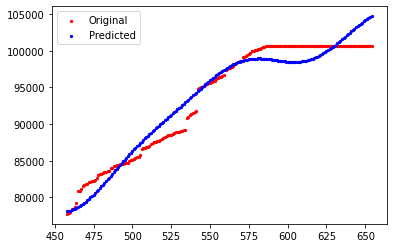

In [5]:
yfit_scaled = svr.predict(x_test_scale)
yfit_scaled = np.array(yfit_scaled).reshape(-1, 1)
yfit = scalarY.inverse_transform(yfit_scaled)

print(x_test.shape)

plt.scatter(x_test, y_test, s = 5, color = "red", label = "Original")
plt.scatter(x_test, yfit, s = 5, color = "blue", label = "Predicted")
plt.legend()
plt.show()

Test Scores

In [6]:
score = svr.score(x_test_scale, y_test_scale)
print("R-squared : ", score)
MSE = mean_squared_error(y_test, yfit)
print("MSE : ", MSE)

R-squared :  0.9441521958143753
MSE :  3161893.6093935035
